In [ ]:
### langchain, ## may test use tool node and agent 
## https://langchain-ai.github.io/langgraph/how-tos/tool-calling-errors/
#https://langchain-ai.github.io/langgraph/how-tos/tool-calling-errors/#using-the-prebuilt-toolnode
#https://paynelab.github.io/cptac/usecase05_enrichment_analysis.html

In [13]:
from langchain import OpenAI, LLMMathChain, SerpAPIWrapper
from langchain.chat_models import ChatOpenAI
from langchain.chains.conversation.memory import ConversationBufferWindowMemory
from langchain.agents import initialize_agent, Tool, AgentType
from langchain.tools import BaseTool
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain_anthropic import ChatAnthropic
from langchain_core.tools import tool
import json, os
import requests
import pandas as pd
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langchain.memory import ConversationBufferMemory
import uuid
from typing import Literal
memory = MemorySaver()

In [4]:
os.environ['OPENAI_API_KEY']=API_KEY
os.environ["TAVILY_API_KEY"]=Tav_API_KEY

In [5]:
#### working one
class State(TypedDict):
    messages: Annotated[list, add_messages]
    
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620",
                    anthropic_api_key='')

############################################################################################################
### test API case use my function, not depdent on lainchain library
import pandas as pd
import gseapy as gp
################ New ######################################################################################
target_gl=['HBG1', 'GATA2', 'ANKRD22', 'LHX4', 'PSMD9', 'APH1A', 'TRAPPC4', 'KRAS', 'TP53', 'PTCH1', 'DNMT3A', 'PTPRS', 'JAK2', 'TNFAIP3', 'BRCA1', 'ASXL1', 'PTCH1', 'DNMT3A', 'PTPRS', 'JAK2', 'EGFR', 'PTEN']


In [6]:
###################### working !!!
from typing import List, Union
from pydantic import BaseModel, ValidationError
import gseapy as gp


# Define input schema using Pydantic
class EnrichrInput(BaseModel):
    inputgenelist: List[str]

# Define the Enrichr API function
def enrichr_api(input_data: Union[dict, list]) -> dict:
    """
    Perform enrichment analysis using the Enrichr API.

    Args:
        input_data (Union[dict, list]): Input data with a list of gene symbols.
            If a list is provided, it will be wrapped in a dictionary with the key 'inputgenelist'.

    Returns:
        dict: Enrichment results or error details.
    """
    try:
        # If input_data is a list, wrap it in a dictionary
        if isinstance(input_data, list):
            input_data = {"inputgenelist": input_data}

        # Validate input using the Pydantic schema
        validated_input = EnrichrInput(**input_data)
        
        # Access the gene list from the validated input
        gene_list = validated_input.inputgenelist

        # Perform enrichment analysis
        enr = gp.enrichr(
            gene_list=gene_list, 
            gene_sets='KEGG_2016', 
            outdir='test/enrichr_kegg_tumor'
        )
        
        # Extract top results as JSON
        enrichment_results = enr.res2d.head().to_dict(orient='records')

        return {
            "enrichment_results": enrichment_results
        }
    except ValidationError as e:
        return {
            "error": f"Validation error: {e.errors()}"
        }
    except Exception as e:
        return {
            "error": str(e)
        }

# Tool definition for LangChain
enrichr_tool = Tool.from_function(
    name="enrichr_api",
    func=enrichr_api,
    description="Perform enrichment analysis using the Enrichr API. Input: gene list as a list of strings. Output: Enrichment results.",
    args_schema=EnrichrInput
)

# Bind the tool to the LLM
llm_with_tools = llm.bind_tools([enrichr_tool])

# Example gene list


In [7]:
# Correct invocation
result = enrichr_tool.invoke({"inputgenelist": target_gl})

# Print the result
print(result)

{'enrichment_results': [{'Gene_set': 'KEGG_2016', 'Term': 'Endometrial cancer Homo sapiens hsa05213', 'Overlap': '4/52', 'P-value': 1.2098570270927802e-07, 'Adjusted P-value': 7.088801821799391e-06, 'Old P-value': 0, 'Old Adjusted P-value': 0, 'Odds Ratio': 118.6547619047619, 'Combined Score': 1889.884809446178, 'Genes': 'PTEN;KRAS;TP53;EGFR'}, {'Gene_set': 'KEGG_2016', 'Term': 'MicroRNAs in cancer Homo sapiens hsa05206', 'Overlap': '6/297', 'P-value': 1.6288851047270544e-07, 'Adjusted P-value': 7.088801821799391e-06, 'Old P-value': 0, 'Old Adjusted P-value': 0, 'Odds Ratio': 33.833333333333336, 'Combined Score': 528.821761760631, 'Genes': 'DNMT3A;PTEN;KRAS;BRCA1;TP53;EGFR'}, {'Gene_set': 'KEGG_2016', 'Term': 'Glioma Homo sapiens hsa05214', 'Overlap': '4/65', 'P-value': 3.003720406162296e-07, 'Adjusted P-value': 7.088801821799391e-06, 'Old P-value': 0, 'Old Adjusted P-value': 0, 'Odds Ratio': 93.30679156908666, 'Combined Score': 1401.3041621971267, 'Genes': 'PTEN;KRAS;TP53;EGFR'}, {'Ge

In [8]:
#print({"inputgenelist": target_gl})

{'inputgenelist': ['HBG1', 'GATA2', 'ANKRD22', 'LHX4', 'PSMD9', 'APH1A', 'TRAPPC4', 'KRAS', 'TP53', 'PTCH1', 'DNMT3A', 'PTPRS', 'JAK2', 'TNFAIP3', 'BRCA1', 'ASXL1', 'PTCH1', 'DNMT3A', 'PTPRS', 'JAK2', 'EGFR', 'PTEN']}


In [10]:
#result = enrichr_api({"inputgenelist": target_gl})
#print(result)

{'enrichment_results': [{'Gene_set': 'KEGG_2016', 'Term': 'Endometrial cancer Homo sapiens hsa05213', 'Overlap': '4/52', 'P-value': 1.2098570270927802e-07, 'Adjusted P-value': 7.088801821799391e-06, 'Old P-value': 0, 'Old Adjusted P-value': 0, 'Odds Ratio': 118.6547619047619, 'Combined Score': 1889.884809446178, 'Genes': 'PTEN;KRAS;TP53;EGFR'}, {'Gene_set': 'KEGG_2016', 'Term': 'MicroRNAs in cancer Homo sapiens hsa05206', 'Overlap': '6/297', 'P-value': 1.6288851047270544e-07, 'Adjusted P-value': 7.088801821799391e-06, 'Old P-value': 0, 'Old Adjusted P-value': 0, 'Odds Ratio': 33.833333333333336, 'Combined Score': 528.821761760631, 'Genes': 'DNMT3A;PTEN;KRAS;BRCA1;TP53;EGFR'}, {'Gene_set': 'KEGG_2016', 'Term': 'Glioma Homo sapiens hsa05214', 'Overlap': '4/65', 'P-value': 3.003720406162296e-07, 'Adjusted P-value': 7.088801821799391e-06, 'Old P-value': 0, 'Old Adjusted P-value': 0, 'Odds Ratio': 93.30679156908666, 'Combined Score': 1401.3041621971267, 'Genes': 'PTEN;KRAS;TP53;EGFR'}, {'Ge

In [11]:
import json
from langchain_core.messages import ToolMessage
class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = ToolNode([enrichr_api])

In [14]:
def should_continue(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END
def should_fallback(
    state: MessagesState,
) -> Literal["agent", "remove_failed_tool_call_attempt"]:
    messages = state["messages"]
    failed_tool_messages = [
        msg
        for msg in messages
        if isinstance(msg, ToolMessage)
        and msg.additional_kwargs.get("error") is not None
    ]
    if failed_tool_messages:
        return "remove_failed_tool_call_attempt"
    return "agent"

def call_model(state: MessagesState):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

def remove_failed_tool_call_attempt(state: MessagesState):
    messages = state["messages"]
    # Remove all messages from the most recent
    # instance of AIMessage onwards.
    last_ai_message_index = next(
        i
        for i, msg in reversed(list(enumerate(messages)))
        if isinstance(msg, AIMessage)
    )
    messages_to_remove = messages[last_ai_message_index:]
    return {"messages": [RemoveMessage(id=m.id) for m in messages_to_remove]}


# Fallback to a better model if a tool call fails
def call_fallback_model(state: MessagesState):
    messages = state["messages"]
    response = better_model_with_tools.invoke(messages)
    return {"messages": [response]}



workflow = StateGraph(MessagesState)

########
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)
workflow.add_node("remove_failed_tool_call_attempt", remove_failed_tool_call_attempt)
workflow.add_node("fallback_agent", call_fallback_model)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue, ["tools", END])
workflow.add_conditional_edges("tools", should_fallback)
workflow.add_edge("remove_failed_tool_call_attempt", "fallback_agent")
workflow.add_edge("fallback_agent", "tools")

app = workflow.compile()

##########
# Define the two nodes we will cycle between
#workflow.add_node("agent", call_model)
#workflow.add_node("tools", tool_node)

#workflow.add_edge(START, "agent")
#workflow.add_conditional_edges("agent", should_continue, ["tools", END])
#workflow.add_edge("tools", "agent")

#app = workflow.compile()
#app = workflow.compile(checkpointer=memory)
# The thread id is a unique key that identifies
# this particular conversation.
# We'll just generate a random uuid here.
# This enables a single application to manage conversations among multiple users.
thread_id = uuid.uuid4()
config = {"configurable": {"thread_id": thread_id}}


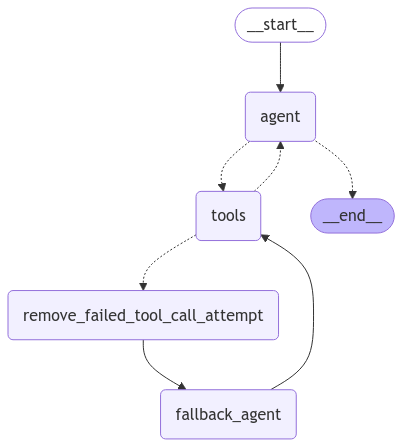

In [15]:
from IPython.display import Image, display
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [242]:
target_gl=['HBG1', 'GATA2', 'ANKRD22', 'LHX4', 'PSMD9', 'APH1A', 'TRAPPC4', 'KRAS', 'TP53', 'PTCH1', 'DNMT3A', 'PTPRS', 'JAK2', 'TNFAIP3', 'BRCA1', 'ASXL1', 'PTCH1', 'DNMT3A', 'PTPRS', 'JAK2', 'EGFR', 'PTEN']

In [16]:
response = app.invoke(
    {"messages": [("human", "inputgenelist is ['HBG1', 'GATA2', 'ANKRD22', 'LHX4', 'PSMD9', 'APH1A', 'TRAPPC4', 'KRAS', 'TP53', 'PTCH1', 'DNMT3A', 'PTPRS', 'JAK2', 'TNFAIP3', 'BRCA1', 'ASXL1', 'PTCH1', 'DNMT3A', 'PTPRS', 'JAK2', 'EGFR', 'PTEN']")]},
    {"recursion_limit": 10},
)
for message in response["messages"]:
    string_representation = f"{message.type.upper()}: {message.content}\n"
    print(string_representation)

HUMAN: inputgenelist is ['HBG1', 'GATA2', 'ANKRD22', 'LHX4', 'PSMD9', 'APH1A', 'TRAPPC4', 'KRAS', 'TP53', 'PTCH1', 'DNMT3A', 'PTPRS', 'JAK2', 'TNFAIP3', 'BRCA1', 'ASXL1', 'PTCH1', 'DNMT3A', 'PTPRS', 'JAK2', 'EGFR', 'PTEN']

AI: [{'text': "Thank you for providing the input gene list. I'll use the Enrichr API to perform an enrichment analysis on these genes. Let me call the function to get the results for you.", 'type': 'text'}, {'id': 'toolu_01Ndy8YqYizFWCyXbqufRJCa', 'input': {'inputgenelist': ['HBG1', 'GATA2', 'ANKRD22', 'LHX4', 'PSMD9', 'APH1A', 'TRAPPC4', 'KRAS', 'TP53', 'PTCH1', 'DNMT3A', 'PTPRS', 'JAK2', 'TNFAIP3', 'BRCA1', 'ASXL1', 'PTCH1', 'DNMT3A', 'PTPRS', 'JAK2', 'EGFR', 'PTEN']}, 'name': 'enrichr_api', 'type': 'tool_use'}]

TOOL: Error: 1 validation error for enrichr_api
input_data
  Field required [type=missing, input_value={'inputgenelist': ['HBG1'...'JAK2', 'EGFR', 'PTEN']}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.9/v/missing
 Plea

In [17]:
def stream_graph_updates(user_input: str):
    for event in app.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  inputgenelist is ['HBG1', 'GATA2', 'ANKRD22', 'LHX4', 'PSMD9', 'APH1A', 'TRAPPC4', 'KRAS', 'TP53', 'PTCH1', 'DNMT3A', 'PTPRS', 'JAK2', 'TNFAIP3', 'BRCA1', 'ASXL1', 'PTCH1', 'DNMT3A', 'PTPRS', 'JAK2', 'EGFR', 'PTEN']


Assistant: [{'text': "Thank you for providing the input gene list. I'll use the Enrichr API to perform an enrichment analysis on these genes. Let's proceed with the tool call.", 'type': 'text'}, {'id': 'toolu_01RBYooY1do2a3fsx3DghqNQ', 'input': {'inputgenelist': ['HBG1', 'GATA2', 'ANKRD22', 'LHX4', 'PSMD9', 'APH1A', 'TRAPPC4', 'KRAS', 'TP53', 'PTCH1', 'DNMT3A', 'PTPRS', 'JAK2', 'TNFAIP3', 'BRCA1', 'ASXL1', 'PTCH1', 'DNMT3A', 'PTPRS', 'JAK2', 'EGFR', 'PTEN']}, 'name': 'enrichr_api', 'type': 'tool_use'}]
Assistant: Error: 1 validation error for enrichr_api
input_data
  Field required [type=missing, input_value={'inputgenelist': ['HBG1'...'JAK2', 'EGFR', 'PTEN']}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.9/v/missing
 Please fix your mistakes.
Assistant: [{'text': 'I apologize for the error in my previous response. It seems there was a mismatch in the parameter name. Let me correct that and try again with the correct parameter name.', 'type': 'text'}

User:  q


Goodbye!


In [18]:
stream = app.stream(
    {"messages": [("human", "inputgenelist is ['HBG1', 'GATA2', 'ANKRD22', 'LHX4', 'PSMD9', 'APH1A', 'TRAPPC4', 'KRAS', 'TP53', 'PTCH1', 'DNMT3A', 'PTPRS', 'JAK2', 'TNFAIP3', 'BRCA1', 'ASXL1', 'PTCH1', 'DNMT3A', 'PTPRS', 'JAK2', 'EGFR', 'PTEN']")]},
    {"recursion_limit": 10},
)

for chunk in stream:
    print(chunk)

{'agent': {'messages': [AIMessage(content=[{'text': "Thank you for providing the input gene list. I can use this list to perform an enrichment analysis using the Enrichr API. This analysis will help identify biological pathways, functions, or processes that are significantly associated with the genes you've provided. Let's proceed with the enrichment analysis.", 'type': 'text'}, {'id': 'toolu_01Ty43bf2qV2wny5dvkrQbGb', 'input': {'inputgenelist': ['HBG1', 'GATA2', 'ANKRD22', 'LHX4', 'PSMD9', 'APH1A', 'TRAPPC4', 'KRAS', 'TP53', 'PTCH1', 'DNMT3A', 'PTPRS', 'JAK2', 'TNFAIP3', 'BRCA1', 'ASXL1', 'PTCH1', 'DNMT3A', 'PTPRS', 'JAK2', 'EGFR', 'PTEN']}, 'name': 'enrichr_api', 'type': 'tool_use'}], additional_kwargs={}, response_metadata={'id': 'msg_01QnUuDz99F5K8H4EpdhZqTR', 'model': 'claude-3-5-sonnet-20240620', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'cache_creation_input_tokens': 0, 'cache_read_input_tokens': 0, 'input_tokens': 550, 'output_tokens': 249}}, id='run-04238749-